In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
image_1 = cv2.imread("/content/drive/MyDrive/images(panaroma)/sl.jpg")
image_2 = cv2.imread("/content/drive/MyDrive/images(panaroma)/sm.jpg")
image_3 = cv2.imread("/content/drive/MyDrive/images(panaroma)/sr.jpg")

In [19]:
def get_keypoints(image_1, image_2):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_1, descriptor_1 = sift.detectAndCompute(image_1, None)
    keypoints_2, descriptor_2 = sift.detectAndCompute(image_2, None)
    fig, axis = plt.subplots(1, 2, figsize=(10,5))
    axis[0].imshow(cv2.drawKeypoints(image_1, keypoints_1, None))
    axis[0].set_title("first image keypoints")
    axis[1].imshow(cv2.drawKeypoints(image_2, keypoints_2, None))
    axis[1].set_title("second image keypoints")
    return keypoints_1, descriptor_1, keypoints_2, descriptor_2


In [20]:
def get_matches(keypoints_1, descriptor_1, image_1, keypoints_2, descriptor_2,image_2):
    ratio = 0.85
    min_match = 10
    matcher = cv2.BFMatcher()
    raw_matches = matcher.knnMatch(descriptor_1,descriptor_2,k=2)
    good_points = []
    good_matches = []
    for m1, m2 in raw_matches:
        if m1.distance < ratio * m2.distance:
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])
    matches = cv2.drawMatchesKnn(image_1, keypoints_1, image_2, keypoints_1, good_matches, None, flags=2)
    fig, axis = plt.subplots(1, 1, figsize=(5,5))
    axis.imshow(matches)
    axis.set_title("match points")
    if len(good_points) > min_match:
        image1_kp = np.float32([keypoints_1[i].pt for (_, i) in good_points])
        image2_kp = np.float32([keypoints_2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
    return H

In [21]:
def get_mask(img1,img2,version,smoothing_window_size=600):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1,0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0,1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [22]:
def get_panorama(image_1, image_2,H):
    height_img1 = image_1.shape[0]
    width_img1 = image_1.shape[1]
    width_img2 = image_2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    panorama1 = np.zeros((height_panorama, width_panorama, 3))
    mask1 = get_mask(image_1, image_2, version='left_image')
    panorama1[0:image_1.shape[0], 0:image_1.shape[1], :] = image_1
    panorama1 *= mask1
    mask2 = get_mask(image_1,image_2,version='right_image')
    panorama2 = cv2.warpPerspective(image_2, H, (width_panorama, height_panorama))*mask2
    result = panorama1 + panorama2
    rows, cols = np.where(result[:, :, 0] != 0)
    min_row, max_row = min(rows), max(rows) + 1
    min_col, max_col = min(cols), max(cols) + 1
    final_result = result[min_row:max_row, min_col:max_col, :]
    return final_result.astype(np.uint8)

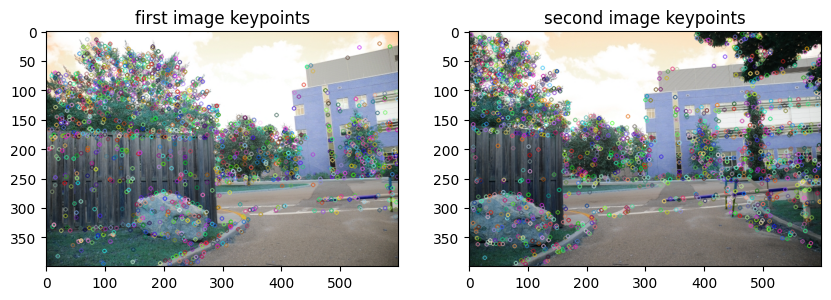

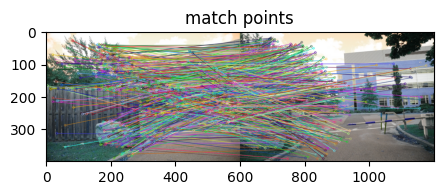

In [23]:
keypoints_1, descriptor_1, keypoints_2, descriptor_2 = get_keypoints(image_1,image_2)
H = get_matches(keypoints_1, descriptor_1, image_1,keypoints_2, descriptor_2,image_2)
final_result_1 = get_panorama(image_1, image_2,H)

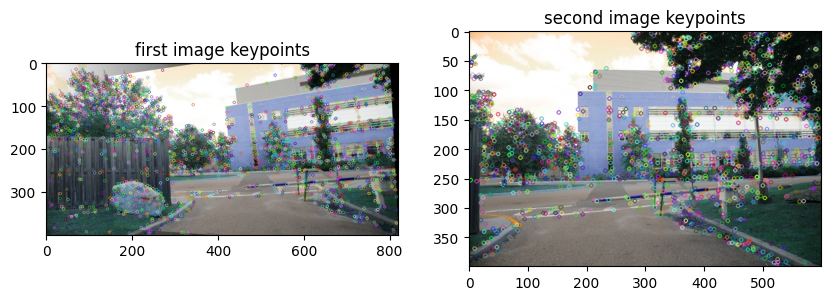

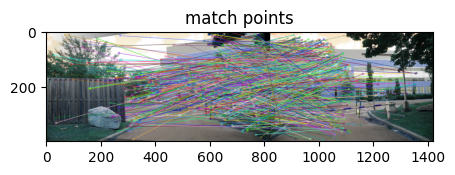

In [24]:
keypoints_1, descriptor_1, keypoints_2, descriptor_2 = get_keypoints(final_result_1,image_3)
H = get_matches(keypoints_1, descriptor_1, final_result_1,keypoints_2, descriptor_2,image_3)
final_result_2 = get_panorama(final_result_1, image_3,H)

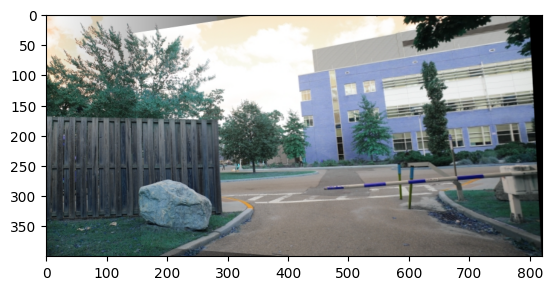

In [25]:
plt.imshow(final_result_1/255.0)
plt.show()

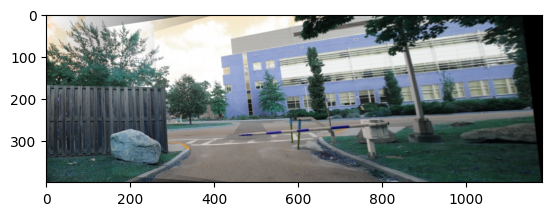

In [26]:
plt.imshow(final_result_2/255.0)
plt.show()
